# import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve

sys.path.append(os.path.abspath('..'))
from src.data_processing import load_data, clean_data, feature_engineer_fraud, transform_data, handle_imbalance
from src.util import save_stats, save_plot

# # laod data

In [3]:
fraud_df = load_data(r"C:\Users\user\Desktop\Project\Adey_Innovations\data\raw\Fraud_Data.csv")
ip_df= load_data(r"C:\Users\user\Desktop\Project\Adey_Innovations\data\raw\IpAddress_to_Country.csv")
creditcard_df= load_data(r"C:\Users\user\Desktop\Project\Adey_Innovations\data\raw\creditcard.csv")


##  Preprocess Fraud Data

In [4]:
print("Preprocessing Fraud Data...")
fraud_df = clean_data(fraud_df)
fraud_df = feature_engineer_fraud(fraud_df, ip_df)
num_cols_fraud = ['purchase_value', 'age', 'hour_of_day', 'time_since_signup', 'device_id_count', 'ip_address_count']
cat_cols_fraud = ['source', 'browser', 'sex']
fraud_transformed, _ = transform_data(fraud_df, cat_cols_fraud, num_cols_fraud)

Preprocessing Fraud Data...


## Drop non-feature columns for fraud data

In [5]:
cols_to_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'country', 'ip_int', 'lower_bound_ip_address', 'upper_bound_ip_address', 'day_of_week']
X_fraud = fraud_transformed.drop(columns=[col for col in cols_to_drop if col in fraud_transformed.columns] + ['class'])
y_fraud = fraud_transformed['class'].astype(int)

print(f"Fraud Features count: {X_fraud.shape[1]}")

Fraud Features count: 16


## Split data using stratified

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (120889, 16)
Test shape: (30223, 16)


# Baseline Model: Logistic Regression

In [7]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     27393
           1       0.90      0.51      0.65      2830

    accuracy                           0.95     30223
   macro avg       0.93      0.75      0.81     30223
weighted avg       0.95      0.95      0.94     30223

ROC AUC Score: 0.8351082573905613


 # Ensemble Model: Random Forest

In [8]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("RF ROC AUC Score:", roc_auc_score(y_test, y_prob_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

RF ROC AUC Score: 0.8411777002171894


# Ensemble Model: XGBoost

In [9]:
X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce').astype(float)
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce').astype(float)

xgb_model = XGBClassifier(
    n_estimators=50, 
    max_depth=5, 
    learning_rate=0.1, 
    random_state=42, 
    eval_metric='logloss'
)

xgb_model.fit(X_train_numeric, y_train)

y_pred_xgb = xgb_model.predict(X_test_numeric)
y_prob_xgb = xgb_model.predict_proba(X_test_numeric)[:, 1]

print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGB ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

XGB ROC AUC Score: 0.8392114309464167


#  Cross-Validation (Stratified K-Fold)

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce').astype(float)

cv_scores = cross_val_score(xgb_model, X_train_numeric, y_train, cv=skf, scoring='roc_auc')

print(f"XGBoost CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

XGBoost CV ROC AUC: 0.8474 (+/- 0.0039)


# Model Comparison and Selection

                 Model   ROC AUC
0  Logistic Regression  0.835108
1        Random Forest  0.841178
2              XGBoost  0.839211


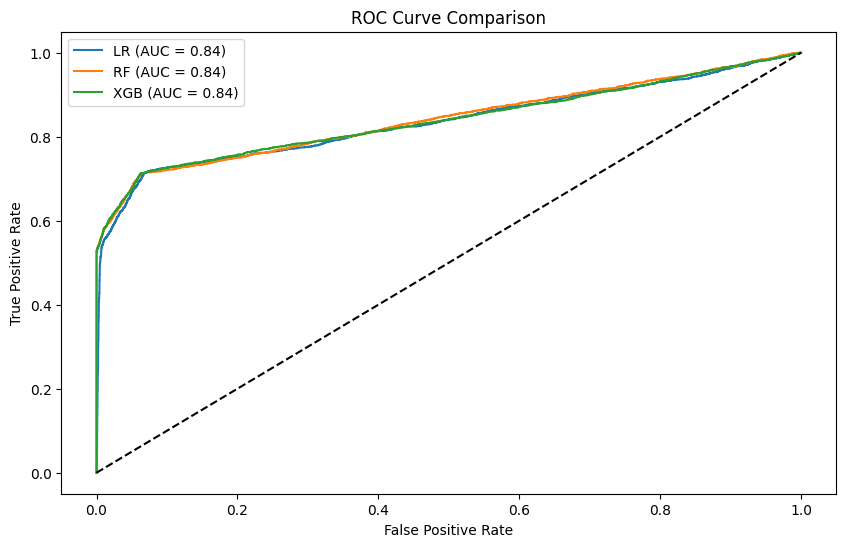

In [11]:
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC AUC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ]
}
results_df = pd.DataFrame(results)
print(results_df)

# ROC Curve Plot
plt.figure(figsize=(10, 6))
for name, prob in zip(['LR', 'RF', 'XGB'], [y_prob_lr, y_prob_rf, y_prob_xgb]):
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, prob):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# save best model

In [31]:

import joblib
from pathlib import Path
from datetime import datetime
project_root = Path(r"C:\Users\user\Desktop\Project\Adey_Innovations\data")
models_dir = project_root / "models"
data_processed_dir = project_root / "data" / "processed"
models_dir.mkdir(parents=True, exist_ok=True)
# Save Random Forest (typically best)
rf_path = save_model(rf_model, "model_random_forest", rf_metrics, models_dir)
print(f"Random Forest saved to: {rf_path}")
# Also save Logistic Regression (for comparison / interpretability)
lr_path = save_model(lr_model, "model_logistic_regression", lr_metrics, models_dir)
print(f"Logistic Regression saved to: {lr_path}")


  


Random Forest saved to: C:\Users\user\Desktop\Project\Adey_Innovations\data\models\model_random_forest.pkl
Logistic Regression saved to: C:\Users\user\Desktop\Project\Adey_Innovations\data\models\model_logistic_regression.pkl
